
  ## **Assignment 1: Bayesian Decision Theory**

---


   
The goal of this exercise is to understand the basic of Bayesian Decision Theory, by implementing a classifier model to distinguish the type of a wine bottle.

Given the alcohol content and the color intensity of a wine bottle, our model will be able to accurately predict the label of it, and categorize it into 1 of 3 labels.



# **Question A: The model**

The model will be able to classify an unlabeled wine, by recognizing the patters from an input training dataset.

In our case, the dataset that we will use is called "parameters.txt". It contains 3 types of wine, along with the count and price of each one aswell as, the mean vector and covariance matrix that defines their distribution.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import matplotlib.patches as mpatches

Calculates the prior probability of each class<br>
Input: A python list containing the count of each sample<br>
Output: A numpy array containing the prior probability of each class




In [ ]:
def prior_prob(samples_list):
  n_samples = np.asarray(samples_list)

  n_samples_sum = sum(n_samples)

  return n_samples/n_samples_sum


In [ ]:
samples_list = [132,273,216]

prior_samples = prior_prob(samples_list)
prior_samples

array([0.21256039, 0.43961353, 0.34782609])

Calculates the likelyhood that an input sample belongs to an input distribution<br>
Input:  sample(k-d vector), k(dimension),  mean(k-d vector), covariance(kxk matrix)<br>
Output:  output likelyhood

In [ ]:
def likelyhood(sample, k, mean, cov):
  power = ((-1/2) * np.transpose((sample - mean)) * np.linalg.inv(cov) * (sample - mean)).item()
  numer = np.e ** (power)
  denom = (((2 * np.pi) ** k)  * np.linalg.det(cov)) ** (1/2)
  return numer/denom


We now want to load our dataset and format it to be able to proccess it.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
df = pd.read_csv("/gdrive/MyDrive/Colab Notebooks/data.csv")

labels_df = df.pop("labels") #seperate 1st column("labels") into seperate array

raw_data = df.to_numpy() #(90,2) array containing samples in pairs {alc_cont - col_int}
print(raw_data)
labels_data = labels_df.to_numpy()#(90,) array containing labels in range [0-2] of each sample


In [ ]:

raw_means = np.asarray([
    [13.744746, 5.528305],
    [12.278732, 3.086620],
    [13.15375, 7.39625]
])


raw_covs = np.asarray([
    [
        [0.213560, 0.233696],
        [0.233696, 1.534063]
    ],
    [
        [0.289406, 0.134241],
        [0.134241, 0.855494]
    ],
    [
        [0.281156, 0.429338],
        [0.429338, 5.340454]
    ]
])

#apply reshape(2,1) on each sample vector of data
data = np.apply_along_axis(lambda x: x.reshape(2,1), axis=1, arr=raw_data)

#apply reshape(2,1) on each mean vector
means = np.apply_along_axis(lambda x: x.reshape(2,1), axis=1, arr=raw_means)

#apply reshape(2,2) on each cov_matrix
covs = []
for i in range(raw_covs.shape[0]):
  covs.append(np.matrix(raw_covs[i].reshape(2,2)))


In [ ]:
def posterior(sample, i, mean, cov):

  num = likelyhood(sample, 2, mean, cov) * prior_samples[i]
  print(num)
  den = sum(likelyhood(sample,2,means[j],covs[j])* prior_samples[j] for j in [0,1,2])
  print(den)
  return num/den

We now have built the mechanisms that will allow us to calculate the posterior probability of a given sample.<br>
For each sample of our dataset, we will find the posterior probability of it belonging to every class(0,1,2) and save it in a 90x3 array called post_arr.<br>
After this, for each sample, we will save the index of the highest posterior probability, essentially classifying that the sample belongs in this class.

In [ ]:
#call posterior for each sample, and pass mean,cov of 1 specific class
#do this for every class
#col_list is a list where each index is a (90,1) vector of the post_prob of all samples beloning in the [index]-class
col_list =  [np.apply_along_axis(lambda x,i,mean,cov: posterior(x.reshape(2,1),i,mean,cov), axis=1, arr=data, i=iter, mean=means[iter], cov=covs[iter]) for iter in range(means.shape[0])]

#concat all indexes of col_list into a (90,3) array
post_arr = np.concatenate(col_list, axis=1)

#(90,1) vector containing the predicted class for each sample
pred_label = np.argmax(post_arr,axis=1)

At this point, we want to calculate the accuracy of our model.<br>
We have an array labels_data that holds the actual class for each sample,<br>
and we have an array pred_label that holds our model's classification

In [ ]:
correct = np.sum(pred_label == labels_data) #find count of correct predictions
prior_acc = correct/data.shape[0] # current accuracy of model
print(f"The accuracy of the classifier is {prior_acc}")

# Calculates the total Value of a given vector
# Input: a (n,1) vector containing values in {0,1,2}
# Output: the sum of all items of input vector
def TotalValue(labels):

  conditions = [labels == 0, labels == 1, labels == 2]
  values = [10, 12, 14]
  sum = np.sum(np.select(conditions, values))
  return sum


print(f"Actual Total Value: {TotalValue(labels_data)}") #true value
print(f"Predicted Total Value: {TotalValue(pred_label)}") #pred value


The accuracy of the classifier is 0.8111111111111111
Actual Total Value: 1080
Predicted Total Value: 1082


# **Question Β: Conditional Risk**

Depending on the label of a sample, there is a price associated with it.
Classifying a sample as label 0, which has a price 10, when in reality it belongs to class 2, which has a price 14, carries a risk, that we like to call "conditional risk".<br>

Our goal in this segment, is to minimize said risk, by scaling the posterior probabilities, with the weight of each action.<br>

We begin by defining the cost matrix of each action.


In [ ]:
#action_cost = np.matrix([ #this is greedy
#    [0, 12/10, 14/10],
#    [10/12, 0, 14/12],
#    [10/14, 12/14, 0]
#])

action_cost = np.matrix([ # this is respect
    [0, 10/12, 10/14],
    [12/10, 0, 12/14],
    [14/10, 14/12, 0]
])

risk_arr = post_arr * action_cost.T
print(risk_arr)

We now want, for each sample, to select the action that minimizes the conditional risk.<br>

We do that, by calling 'argmin' on our new_pred vector.



In [ ]:
new_pred = (np.argmin(risk_arr,axis=1)).reshape(90,)
print(new_pred)
new_correct = np.sum(new_pred == labels_data) #find count of correct predictions

post_acc = new_correct/data.shape[0] # current accuracy of model

print(f"\nThe accuracy of the classifier is {post_acc}")
print(f"Total predicted value: {TotalValue(new_pred)}")

[[2 0 0 0 0 0 2 0 0 1 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 0 2 2 2 2 0 2 2
  2 2 2 0 2 2 0 2 2 2 0 1 2 2 1 2 0 1]]

The accuracy of the classifier is 0.8222222222222222
Total predicted value: 1070


One interesting observation, is that the total predicted value of our wines has actually decreased, when accounting for the conditional risk. This is mostly due to 2 main factors, the overlap that exists in the labels' distributions and our attempt to maximize the customers' satisfaction.<br>

Firstly we notice that, while label_0's distribution is less spread out than that of label_2's, their mean vectors are quite similar. More importantly, the prior probability of a random sample belonging to label_0 is less than both of the other labels as, n_samples_0 < n_samples_2 < n_samples_1.   <br>

A happy customer is a returning customer. The last thing any company wants, are customers that feel like they were ripped off. To prevent this, we want to avoid classifying an expensive wine, represented by the label 2, as a cheaper one, with label 0. To achieve this, we scale each action (classifying a sample as label 0,1,2), and we choose the one with the minimum conditional risk.<br>

This will introduce some bias to the model, making it more susceptible to undervalue an expensive wine, in the expense of the company, rather than the customer. <br>

On the other hand, if the company cares more about maximizing its profits, rather than keeping its customers happy, all we have to do is flip the action cost matrix. We can clearly see that, some wines that our previous model preferred to classify them as the lower priced ones, this more 'greedy' one, classifies them as the expensive ones.


In [ ]:
action_cost = np.matrix([
    [0, 12/10, 14/10],
    [10/12, 0, 14/12],
    [10/14, 12/14, 0]
])


risk_arr = post_arr * action_cost.T
new_pred = (np.argmin(risk_arr,axis=1)).reshape(90,)
print(new_pred)
new_correct = np.sum(new_pred == labels_data) #find count of correct predictions

post_acc = new_correct/data.shape[0] # current accuracy of model

print(f"\nThe accuracy of the classifier is {post_acc}")
print(f"Total predicted value: {TotalValue(new_pred)}")

[[2 0 0 0 0 2 2 2 2 1 0 0 0 2 0 0 0 2 0 0 0 1 0 2 0 0 0 1 0 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 0 2 2
  2 2 2 1 2 2 0 2 2 2 0 2 2 2 1 2 0 2]]

The accuracy of the classifier is 0.7888888888888889
Total predicted value: 1102


# **Question C: Plot Results**

In order to get a better understanding of how the model's classification works, we can plot our distributions and visually analyze and check, that everything is in order.

In [ ]:
def graphScatter(sc_list, subplot, title):
    colors = ["r", "g", "b"]
    i = 0
    # plot scatter of each class
    for sc_n in sc_list:
        subplot.scatter(sc_n[:, 0], sc_n[:, 1], c=colors[i], marker='o')
        i += 1

    # plot distributions
    subplot.contourf(xx, yy, Z, cmap='Reds', alpha=0.4)
    subplot.contourf(xx, yy, Z1, cmap='Greens', alpha=0.4)
    subplot.contourf(xx, yy, Z2, cmap='Blues', alpha=0.4)

    # title formating
    subplot.set_xlabel('alc_cont')
    subplot.set_ylabel('col_int')
    subplot.title.set_text(title)

    # legend formating
    red_patch = mpatches.Patch(color='red', label="class_0")
    green_patch = mpatches.Patch(color='g', label="class_1")
    blue_patch = mpatches.Patch(color='b', label='class_2')

    subplot.legend(handles=[red_patch, green_patch, blue_patch])

In [ ]:
    margin = 1.5
    xlim = (np.min(raw_data, axis=0)[0] - margin, np.max(raw_data, axis=0)[0] + margin)
    ylim = (np.min(raw_data, axis=0)[1] - margin, np.max(raw_data, axis=0)[1] + margin)
    sample_rate = 70

    # Define the space
    xg = np.linspace(xlim[0], xlim[1], sample_rate)
    yg = np.linspace(ylim[0], ylim[1], sample_rate)
    xx, yy = np.meshgrid(xg, yg)
    Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T


    # calculate distributions
    Z = (np.apply_along_axis(lambda x: (likelyhood(x.reshape(2, 1), 2, means[0], covs[0]) * prior_samples[0]), axis=1,
                             arr=Xgrid)).reshape(sample_rate, sample_rate)
    Z1 = (np.apply_along_axis(lambda x: (likelyhood(x.reshape(2, 1), 2, means[1], covs[1]) * prior_samples[1]), axis=1,
                              arr=Xgrid)).reshape(sample_rate, sample_rate)
    Z2 = (np.apply_along_axis(lambda x: (likelyhood(x.reshape(2, 1), 2, means[2], covs[2]) * prior_samples[2]), axis=1,
                              arr=Xgrid)).reshape(sample_rate, sample_rate)



    Z_matrix = np.asarray([Z, Z1, Z2])
    pred_Matrix = np.argmax(Z_matrix, axis=0)


    # 3D Plotting
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.contour3D(xx, yy, Z, 100, colors='red')
    ax.contour3D(xx, yy, Z1, 100, colors='blue')
    ax.contour3D(xx, yy, Z2, 100, colors='green')
    ax.set_xlabel('alc_cont')
    ax.set_ylabel('col_int')
    ax.set_zlabel('post_prob')
    ax.set_title('3D contour')




    # 2d contour plot
    figf, axf = plt.subplots(1, 2)

    # creating a scatter plot for each label
    # we are graphing our model's prediction first
    pred_sc_list = [raw_data[pred_label == i] for i in range(post_arr.shape[1])]
    graphScatter(pred_sc_list, axf[0], 'Predicted Labels')

    # creating a scatter plot for each label
    # we now graph the actual labels of each sample
    real_sc_list = [raw_data[labels_data == i] for i in range(post_arr.shape[1])]
    graphScatter(real_sc_list, axf[1], 'Actual Labels')

    axf[0].contour(xx,yy, pred_Matrix)
    axf[1].contour(xx, yy, pred_Matrix)

    plt.show()


Below we can see a 3d plot of the 3 distributions.
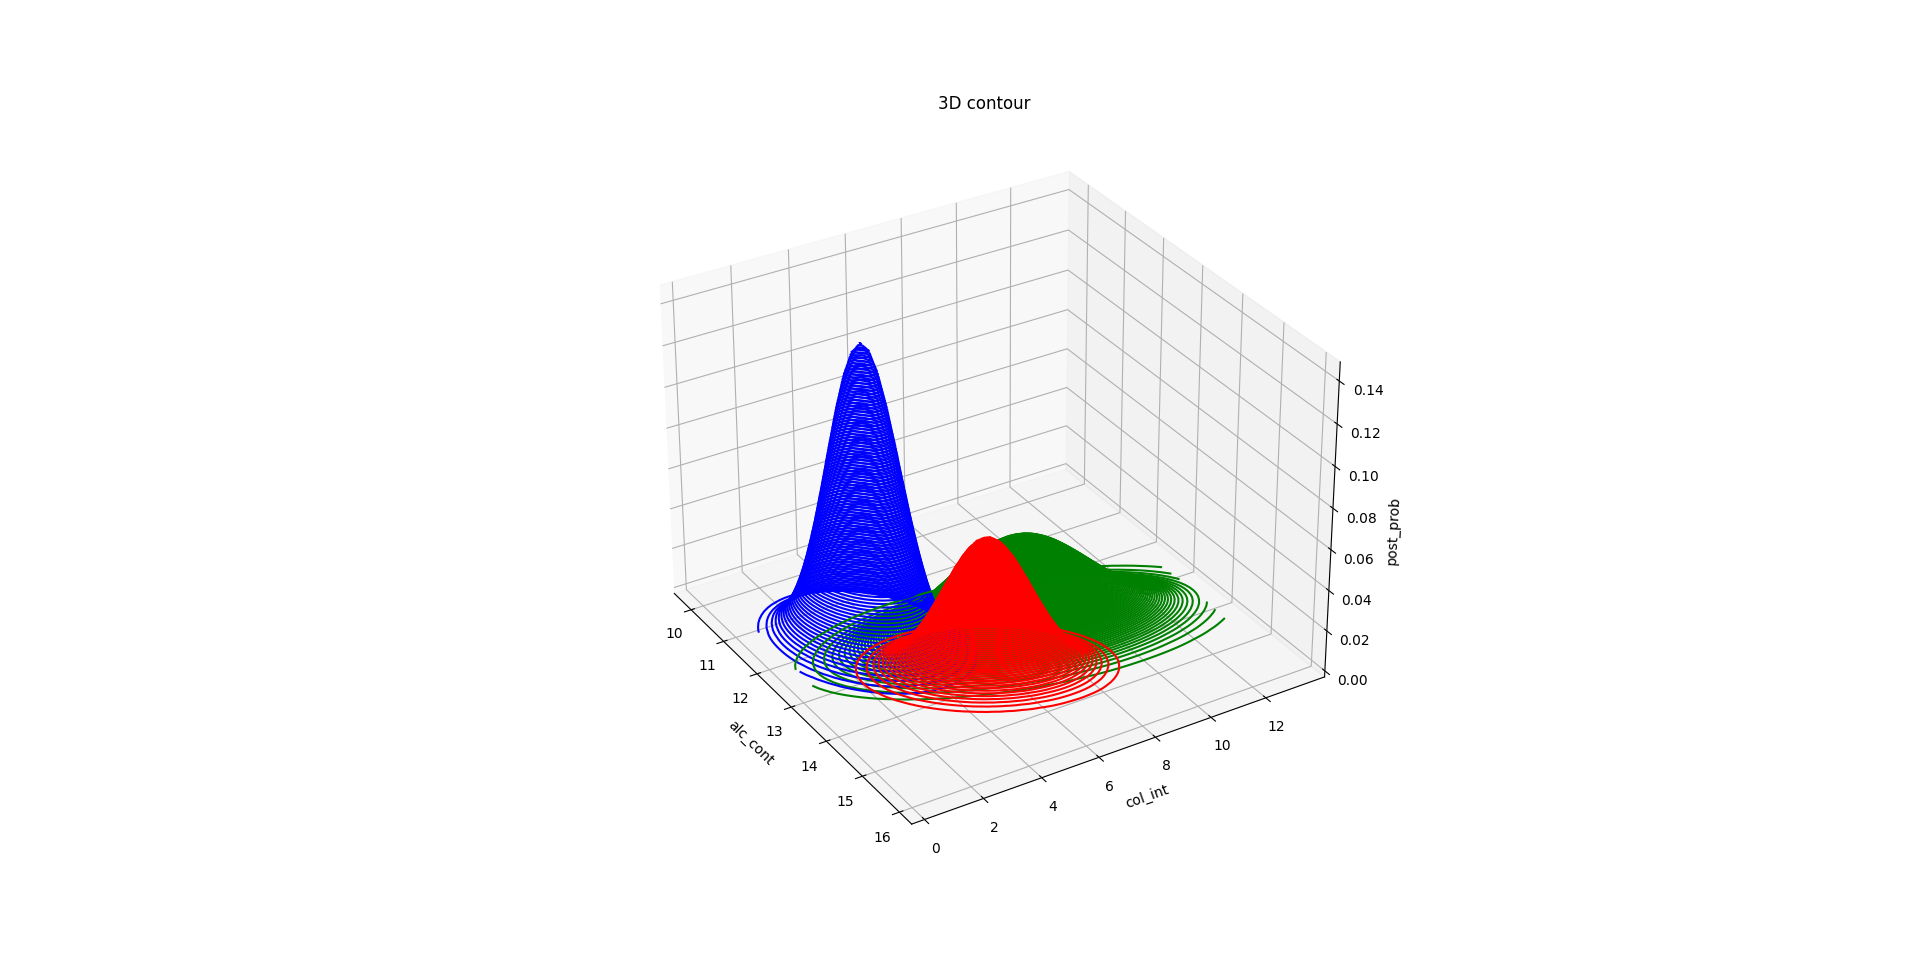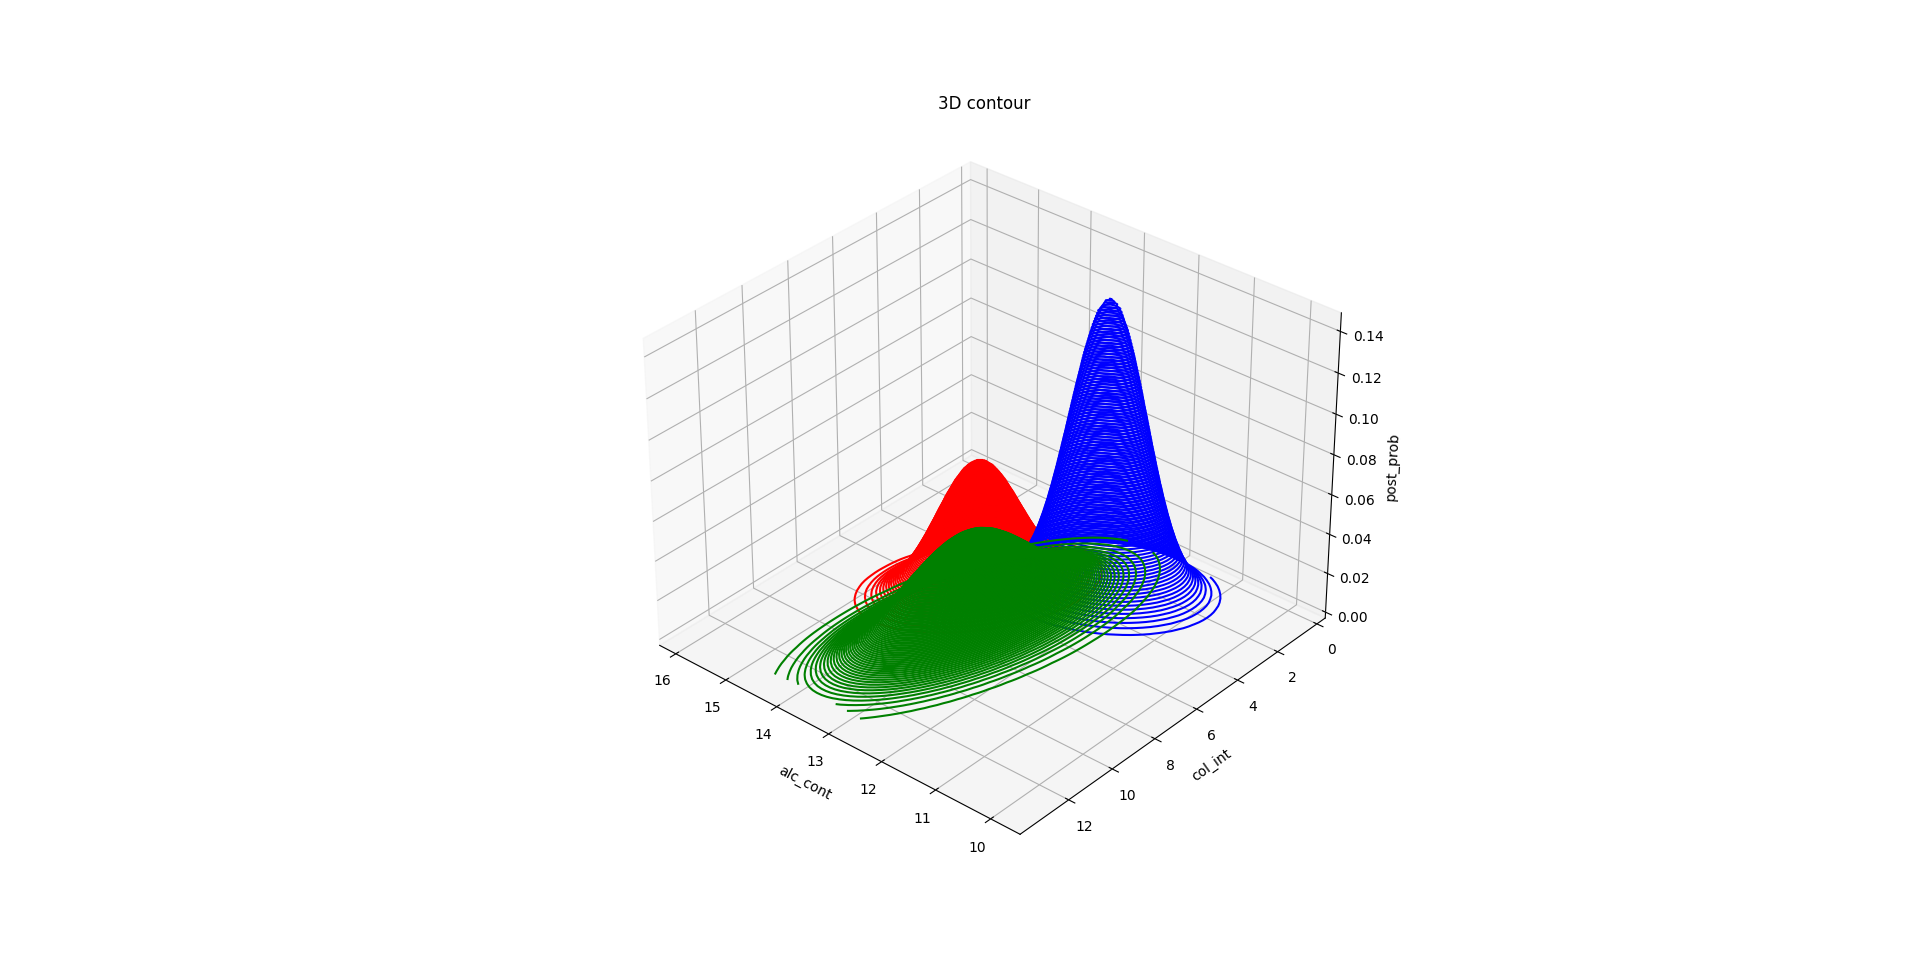

And, in order to thoroughly examine our classifer, we can plot a 2d scatter plot alongside the decision boundaries of each class.<br>

On the left we see the model's classification of our dataset, and on the right we can see the actual labels of each wine.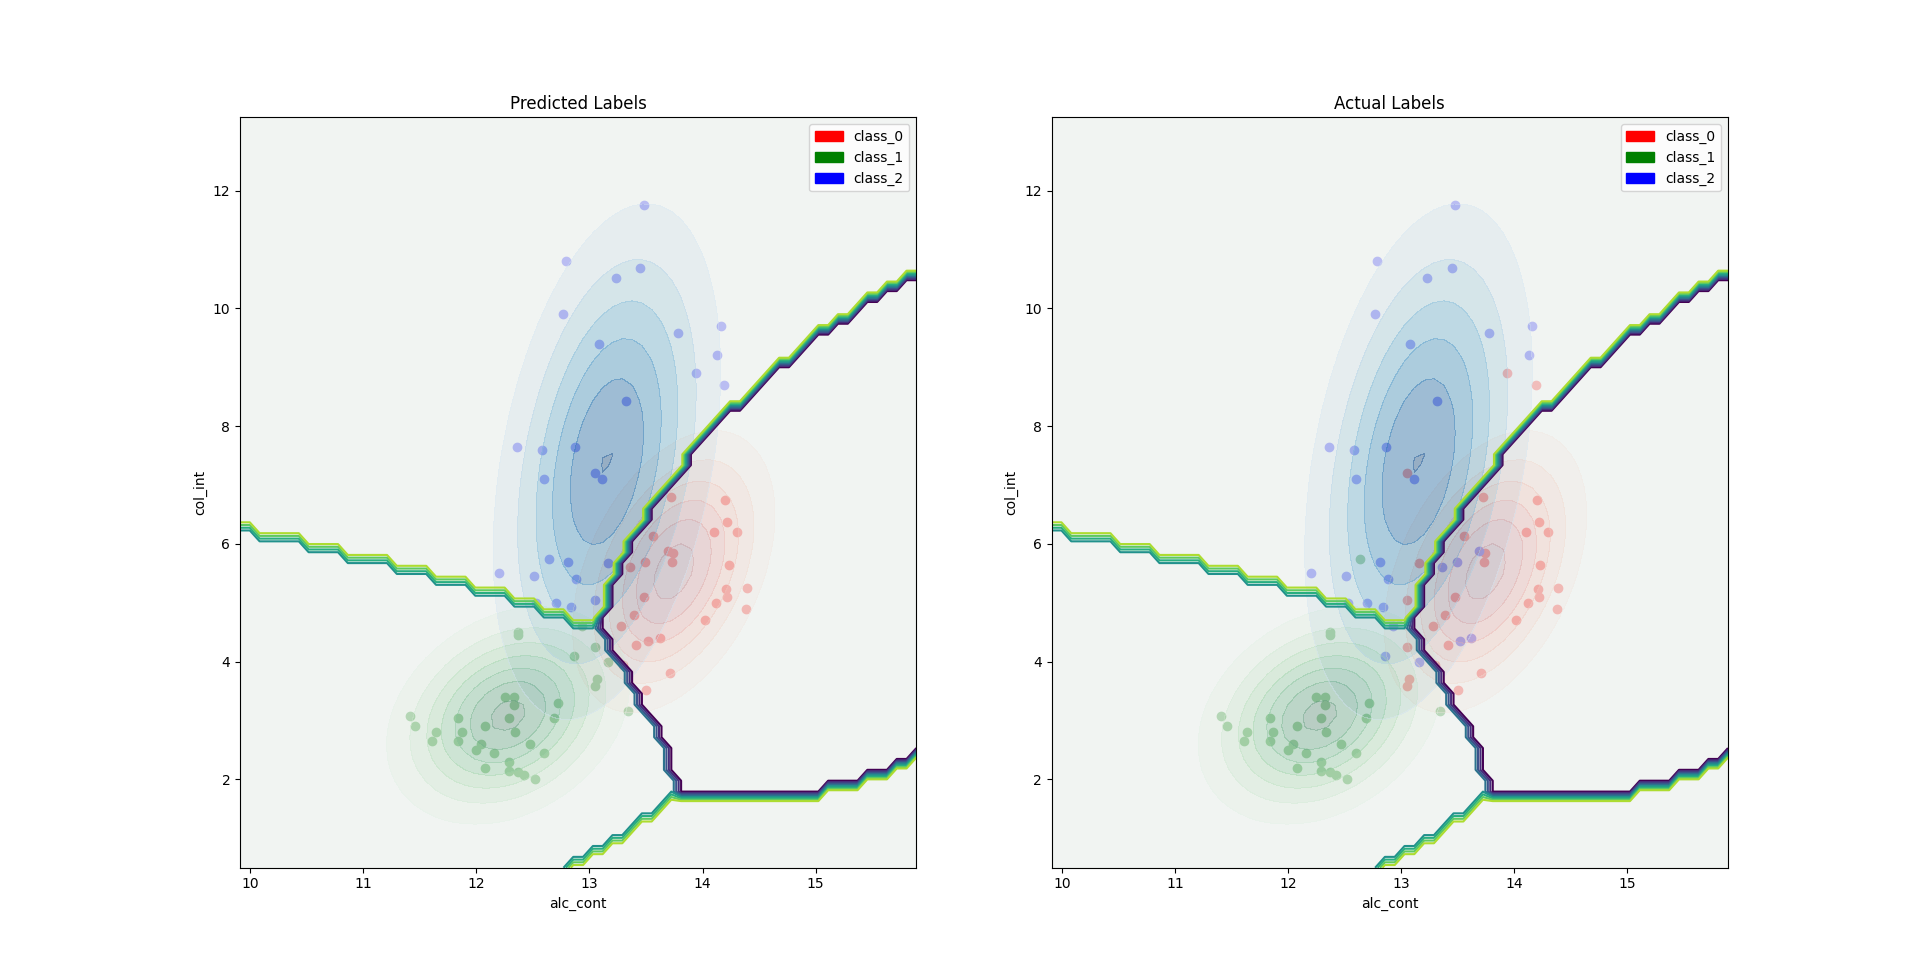